Consider moving notebook to the main directory to avoid path errors.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from torch.amp import autocast
import os
from tqdm import tqdm

from Training.Data.Modules.custom_loader import CustomLoader 
from Utils.model_utils import *; 
from Utils.configs import conf
from XAI_Method.causal_effect_effic import Causal
from XAI_Applications.deletion_AUC import deletion_auc
from Training.Utils.train_utils import accuracy
from Training.Trainer.BaseTrainer import BaseTrainer
from XAI_Applications.deletion_AUC import benchmark_on_batch

In [2]:
config = conf['simpleDNNTMnist']
data_loader = CustomLoader(config["dataset"], True, config["batch_size"], shuffle_test=True)
model = get_model_architecture(config['model_name'], config['model_layers'] + [config["num_classes"]])

In [ ]:
class SimpleTrainer(BaseTrainer):

    def __init__(self, model, data, config, num_samples):

        super().__init__(model, config, data, num_samples)
        
        self.dev = 'cuda' if torch.cuda.is_available() else "cpu"
        self.loss = nn.CrossEntropyLoss()

        os.makedirs(os.getcwd() + f"/Results/Experiments/04_theory_vs_practice", exist_ok=True)

        self.R1, self.R2 = torch.zeros_like(self.R_norm), torch.zeros_like(self.R_norm) 

    def train(self):
                    
        for epoch in range(1, self.epochs + 1):
            
            train_bar = tqdm(enumerate(self.train_load), 
                        desc=f"Epoch: {epoch}/{self.epochs}",
                        total=len(self.train_load)
                    )
            
            self.model.train()
            for batch in train_bar:
                R, R1, R2 = self.train_on_batch(batch[1])
                self.R_norm += R; self.R1 += R1; self.R2 += R2

            self.scheduler.step()

            self.model.eval()
            metrics = np.zeros(len(self.test_load.dataset))
            batch_size = 0

            test_bar = tqdm(enumerate(self.test_load), 
                        desc=f"Epoch: {epoch}/{self.epochs}",
                        total=len(self.test_load)
                    )

            for batch in test_bar:
                l = self.validate_on_batch(batch[1])

                bs = batch[1][0].size(0)
                metrics[batch_size: batch_size+bs] = l.cpu().numpy()
                batch_size += batch[1][0].size(0)

            print(f"Epoch {epoch}, Accuracy: {np.mean(metrics)}")        
            self.train_logs.append(np.mean(metrics))
        
    def apply_loss(self, y_pred, y):

        y_pred = y_pred.reshape((-1, y_pred.shape[-1]))
        y = y.reshape((-1,))

        if y[0].dtype == torch.int or torch.float32: y = y.long()

        return self.loss(y_pred, y)

    def train_on_batch(self, batch):

        # self.model_prev = deepcopy(self.model)
        self.model_state = {k: v.detach().clone() for k, v in self.model.state_dict().items()}

        # Get data from batch, calculate loss and update
        images, labels = batch[0], batch[1]
        images = images.to(self.device); labels = labels.to(self.device)

        self.optimizer.zero_grad()
        with autocast(device_type=self.dev):  # Enable mixed-precision

            output = self.forward(images)
            l = self.apply_loss(output, labels)

        self.scaler.scale(l).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        self.upd_model_state = {k: v.detach().clone() for k, v in self.model.state_dict().items()}

        R, R1, R2 = self.update_R()   
        self.model.load_state_dict(self.upd_model_state) 
        
        return R, R1, R2

    def validate_on_batch(self, batch):

        images, labels = batch[0], batch[1]
        images = images.to(self.device)
        labels = labels.to(self.device)

        with torch.no_grad():
            output = self.forward(images)

        acc = accuracy(output, labels, averaged=False)
        return acc
    
    def update_R(self):

        cause = Causal(self.model, self.model_state, self.X, self.labels)
        # cause = CausalLast(self.model_prev, self.model, self.X, self.labels, True)
        return cause.update(disent=True)  # aggregate=False

In [4]:
def check_differences(model, data, config):

    # Apply two steps for the trainer, get models
    trainer = SimpleTrainer(model, data, config, 40)
    trainer.train()

    return trainer, trainer.R_norm, trainer.R1, trainer.R2

def plot(X, samples, R, R1, R2):

    for i in range(len(samples)):
        for j, x in enumerate([X[samples[i], :], R1[samples[i], :], R2[samples[i], :], R[samples[i], :]]):

            tit = f'sample_{i}' if j==0 else f'theory_{i}' if j==1 else f'practice_{i}' if j==2 else f'comb_{i}'
            plt.imshow(x.reshape(28, 28)); plt.axis('off')
            plt.savefig(os.getcwd() + f"/Results/Experiments/03_theory_vs_practice/{tit}.pdf", 
                            bbox_inches='tight', format='pdf')
            plt.close()

def calc_deletion_AUC(model, X, labels, R, R1, R2):

    model.eval()
    results = {"compl": [], "theor": [], "pract": []}
    for j, mth in enumerate([R, R1, R2]):

        for i, x in enumerate(X):  

            method = "compl" if j==0 else "theor" if j==1 else "pract"
            auc_value, _ = deletion_auc(model, x.to('cuda'), mth[i, :].to('cuda'), labels[i], baseline_val=0.6, steps=200)

            try:
                results[method].append(auc_value)
            except Exception as e:
                results[method].append(np.nan)
            
    res_pth = os.getcwd() + "/Results/Experiments/03_theory_vs_practice"
    with open(f"{res_pth}/compare_methods.txt", "a+") as f:

        for method, auc_list in results.items():
            avg_auc = np.nanmean(auc_list)
            f.write(f"Average Deletion AUC for {method:20s}: {avg_auc:.4f} \n")

def plot_all(X, samples, R1, R2, R):
    xaxis = len(samples)
    _, ax = plt.subplots(xaxis, 4)

    for i in range(len(samples)):

        ax[i, 0].imshow(X[samples[i], :].reshape(28, 28)); ax[i, 0].axis('off')
        ax[i, 1].imshow(R1[samples[i], :].reshape(28, 28)); ax[i, 1].axis('off')
        ax[i, 2].imshow(R2[samples[i], :].reshape(28, 28)); ax[i, 2].axis('off')
        ax[i, 3].imshow(R[samples[i], :].reshape(28, 28)); ax[i, 3].axis('off')
    
    plt.show()

In [10]:
trainer, R, R1, R2 = check_differences(model, data_loader, config)

Saving results in /home/theo-root/Documents/2_Projects/XTRAIN/Results/Datasets/typeface_mnist/run_5


Epoch: 1/10: 100%|██████████| 94/94 [00:01<00:00, 70.10it/s]

Epoch 1, Accuracy: 0.4240802675585284



Epoch: 2/10: 100%|██████████| 94/94 [00:01<00:00, 75.06it/s]

Epoch 2, Accuracy: 0.6520066889632107



Epoch: 3/10: 100%|██████████| 94/94 [00:01<00:00, 71.54it/s]

Epoch 3, Accuracy: 0.6063545150501672



Epoch: 4/10: 100%|██████████| 94/94 [00:01<00:00, 70.43it/s]

Epoch 4, Accuracy: 0.8031772575250836



Epoch: 5/10: 100%|██████████| 94/94 [00:01<00:00, 67.04it/s]

Epoch 5, Accuracy: 0.8755852842809364



Epoch: 6/10: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s]

Epoch 6, Accuracy: 0.8319397993311036



Epoch: 7/10: 100%|██████████| 94/94 [00:01<00:00, 64.02it/s]

Epoch 7, Accuracy: 0.8464882943143812



Epoch: 8/10: 100%|██████████| 94/94 [00:01<00:00, 74.41it/s]

Epoch 8, Accuracy: 0.8750836120401337



Epoch: 9/10: 100%|██████████| 94/94 [00:01<00:00, 75.04it/s]

Epoch 9, Accuracy: 0.9280936454849499



Epoch: 10/10: 100%|██████████| 94/94 [00:01<00:00, 68.68it/s]

Epoch 10, Accuracy: 0.9173913043478261


In [12]:
X = trainer.X.detach().cpu()
labels = trainer.labels
R1, R2, R = R1.detach().cpu(), R2.detach().cpu(), R.detach().cpu()

plot(X, [1, 2, 3, 4, 5, 6], R, R1, R2)

calc_deletion_AUC(model, trainer.X, trainer.labels, R, R1, R2)

methods = ['SHAP', 'LRP', 'GradSHAP', 'IG', 'DeepLIFT'] 
_ = benchmark_on_batch(trainer.model, trainer.X, trainer.labels, 
                    methods, False, os.getcwd()+f"/Results/Experiments/03_theory_vs_practice/",
                    0.6)

Shapley Value Sampling attribution:   0%|          | 0/9801 [00:00<?, ?it/s]

/home/theo-root/miniconda3/envs/xai_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


In [49]:
plot(X, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], R, R1, R2)

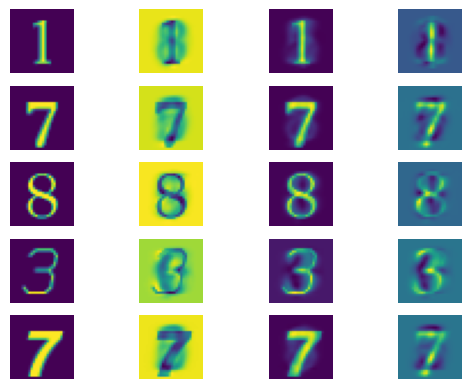

In [51]:
plot_all(X, [1, 2, 3, 4, 5], R1, R2, R)

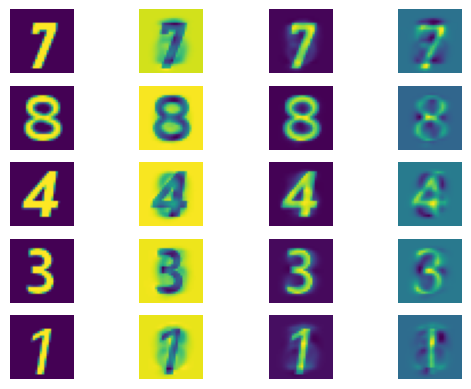

In [52]:
plot_all(X, [6, 7, 8, 9, 10], R1, R2, R)